## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [1]:
import pandas as pd
import numba as nb
import numpy as np
import timeit

import matplotlib.pyplot as plt

from rectools import Columns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
qid_query = pd.read_csv("yandex_data/hidden_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("yandex_data/hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("yandex_data/hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])


In [3]:
hostid_url

,hostid,url
0,1,http://09spravki.ru/requisites.php
1,10,http://3pu.info/seo-tools/domains
2,1006,http://www.priroda.su/item/820
3,1007,http://www.prisnilos.su/znaki_zodiaka/strelets...
4,1009,http://www.prohotel.ru/hotel-108042/0/
...,...,...
798,991,http://www.phototopic.ru/photo-art/
799,992,http://www.piplz.ru/page.php?id=183
800,995,http://www.playground.ru/cheats/il-2_shturmovi...
801,995,http://www.playground.ru/files/907/


### Яндекс версия plook

In [36]:
# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
p=0.15
k = 10

def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


In [39]:
def mean_pfound(df, k, p_break):
    #удаляем адреса ссылок за ненадобностью
    df = df.drop(['url'], axis=1)
    # для каждого запроса оставляем одну ссылку(один хост)
    grouped_qid_rating_hostid = df.groupby(['qid', 'hostid']).max()
    #cортируем хосты по рейтингу
    grouped_qid_rating_hostid = grouped_qid_rating_hostid.sort_values(['qid', 'rating'], ascending=False)
    #нумеруем выдачу по убыванию рейтинга
    grouped_qid_rating_hostid['order'] = grouped_qid_rating_hostid.groupby('qid').cumcount() + 1 
    #выбираем топ к рекомендаций
    topk_recs_for_qid = grouped_qid_rating_hostid[grouped_qid_rating_hostid['order'] <= k] 
    topk_recs_for_qid = topk_recs_for_qid.reset_index()
    #добавляем столбец с рел-1
    topk_recs_for_qid['pred_pReil'] = topk_recs_for_qid['rating'].shift(1) 
    # считаем второй множитель
    topk_recs_for_qid['pLook_second'] = (1 - topk_recs_for_qid['pred_pReil']) * (1 - p_break) 
    # устанавливаем первый второй множитель равный 1
    topk_recs_for_qid.loc[(topk_recs_for_qid['order'] == 1), 'pLook_second'] = 1 
    # счтаем рекурсивно plook
    topk_recs_for_qid['pLook'] = topk_recs_for_qid.groupby('qid')['pLook_second'].cumprod() 
    # считаем всю  формулу
    topk_recs_for_qid['pFound'] = topk_recs_for_qid['pLook'] * topk_recs_for_qid['rating'] 
    
    return topk_recs_for_qid.groupby(['qid']).sum()['pFound'].mean()
    

### Время для нашей версии

In [41]:
%%timeit
res = mean_pfound(qid_url_rating_hostid, 10, 0.15)
res

0.5822199638393889

### Время для версии Яндекса

In [38]:
%%timeit
qid_url_rating_hostid.groupby('qid').apply(pfound).mean()


0.5822199638393889

In [44]:
assert qid_url_rating_hostid.groupby('qid').apply(pfound).mean()==mean_pfound(qid_url_rating_hostid, 10, 0.15)

<h1>MRR</h1>

In [49]:
interactions = pd.read_csv('kion_train/interactions.csv')
interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])
interactions.head()

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [50]:

def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [51]:
df, users, recs = generate_subsample(5, 10)

<h2>Naive MRR</h2>

In [97]:
def mrr_naive(df, users, recs):
    df = df.values
    mrr = 0
    r = 0
    for i, user in enumerate(users):
        r=0
        #рекомендации которые мы предоставили для каждого пользователя
        user_target = df[df[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i], start=1):
            if rec in user_target:
                r = 1/(j)
                mrr+=r
                break
    return mrr/len(users)

In [98]:
mrr_naive(df, users, recs)

0.08002619047619056

<h2>Pandas MRR</h2>

In [58]:
def mrr_pandas(df, users, recs):
    k = recs.shape[1]
    #мапим предикты по юзерам
    df_recs = pd.DataFrame({'user_id': np.repeat(users, k), 'item_id': recs.ravel()})
    #нумеруем
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df['is_rec'] = 1
    # мержим предсказанные рекомендации и топ рекомендаций
    df_recs = df_recs.merge(df, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df_recs['reverse_rank'] = 0
    #считаем обратный ранг
    df_recs.loc[~df_recs['is_rec'].isna(), 'reverse_rank'] = 1/(df_recs.loc[~df_recs['is_rec'].isna(), 'rank'])
    #считаем мрр
    mrr = df_recs.groupby('user_id')['reverse_rank'].max().sum()/len(users)
    return mrr

In [132]:
%%time
mrr_pandas(df, users, recs)


CPU times: user 9.29 ms, sys: 0 ns, total: 9.29 ms
Wall time: 8.7 ms


0.5952380952380951

<h2>Numba MRR</h2>

In [84]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(df,users, recs):
    result_mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrr = 0.0
        user = users[i]
        user_target = df[df[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr = 1 /(j+1)
                break
        result_mrr[i] = mrr
    return result_mrr.mean()


<h2>Посчитаем время выполнения каждого варианта MRR</h2>

In [54]:
k = 10
users_count = 500
df, users, recs = generate_subsample(users_count, k)

In [91]:
%%time
mrr_naive(df, users, recs)


CPU times: user 40.8 ms, sys: 9 µs, total: 40.8 ms
Wall time: 40.1 ms


0.08002619047619056

In [59]:
%%time
mrr_pandas(df, users, recs)


CPU times: user 13.8 ms, sys: 15 µs, total: 13.8 ms
Wall time: 13 ms


0.08002619047619047

In [85]:
%%time
numba_df = df.values
mrr_numba(numba_df, users, recs)

CPU times: user 1.21 s, sys: 4.09 ms, total: 1.21 s
Wall time: 1.2 s


0.06039365079365078

In [99]:

users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

naive_time = []
numba_time = []
pandas_time = []

for k in top_k:
    time_k_naive = []
    time_k_pandas = []
    time_k_numba = []
    
    for j in range(len(users_count)):
        df, users, recs = generate_subsample(users_count[j], k)
        target = df.values
        time = timeit.timeit('mrr_naive(df, users, recs)', "from __main__ import mrr_naive, df, users, recs", number = 3)
        time_k_naive.append(time)
        print("naive time: ", time, " users count: ", users_count[j], " k: ", k)
        time = timeit.timeit('mrr_pandas(df, users, recs)', "from __main__ import mrr_pandas, df, users, recs", number = 3)
        time_k_pandas.append(time)
        print("pandas time:  ", time, " users count: ", users_count[j], " k: ", k)
        time = timeit.timeit('mrr_numba(numba_df, users, recs)', "from __main__ import mrr_numba, numba_df, users, recs", number = 3)
        time_k_numba.append(time)
        print("numba time:  ", time, " users count: ", users_count[j], " k: ", k)

    naive_time.append(time_k_naive)    
    numba_time.append(time_k_numba)    
    pandas_time.append(time_k_pandas)

naive time:  0.010325220006052405  users count:  100  k:  10
pandas time:   0.012334764003753662  users count:  100  k:  10
numba time:   0.0009197469917126  users count:  100  k:  10
naive time:  0.14134516500052996  users count:  1000  k:  10
pandas time:   0.01778558999649249  users count:  1000  k:  10
numba time:   0.004127349995542318  users count:  1000  k:  10
naive time:  5.042027019022498  users count:  10000  k:  10
pandas time:   0.08249898999929428  users count:  10000  k:  10
numba time:   0.034579358994960785  users count:  10000  k:  10
naive time:  406.54885984701104  users count:  100000  k:  10
pandas time:   1.109600190015044  users count:  100000  k:  10
numba time:   0.20909000802203082  users count:  100000  k:  10
naive time:  0.03247371799079701  users count:  100  k:  50
pandas time:   0.01323196801240556  users count:  100  k:  50
numba time:   0.0010488619736861438  users count:  100  k:  50
naive time:  0.3513888629968278  users count:  1000  k:  50
pandas 

<h2>Скорость работы в зависимости от количества пользователей при разном К</h2>

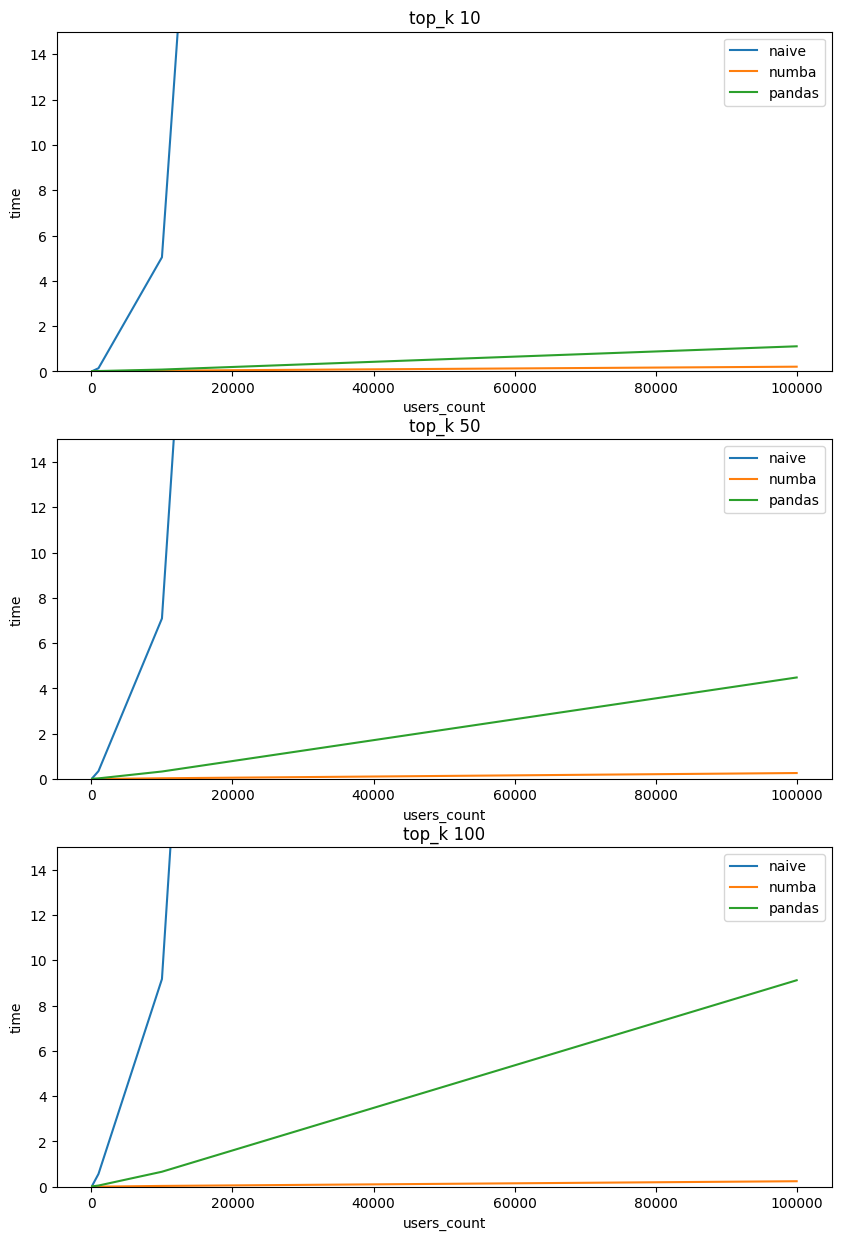

In [109]:
fx, ax = plt.subplots(3, figsize=(10, 15))
for i in range(3):
    ax[i].plot(users_count, naive_time[i], label='naive')
    ax[i].plot(users_count, numba_time[i], label='numba')
    ax[i].plot(users_count, pandas_time[i], label='pandas')
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_ylabel('time')
    ax[i].set_xlabel('users_count')
    ax[i].set_ylim(0, 15)
    ax[i].legend()
plt.show()
